In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
  
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
    
    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
      
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
    
        def _backward():
            self.grad += other * out.grad * (self.data ** (other - 1))
        out._backward = _backward
        
        return out
        
    def __rmul__(self, other):
        return self * other
  
    def __truediv__ (self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out
  
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0, grad=0.0)

In [3]:
# !pip install graphviz

In [4]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Debugging

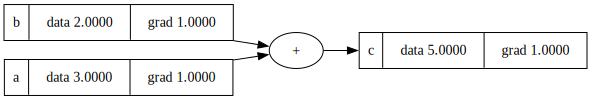

In [5]:
a = Value(3.0, label = 'a')
b = Value(2.0, label = 'b')
c = a + b; c.label = 'c'
c.backward()
draw_dot(c)

## EndDebugging

In [6]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-22.120199999999997


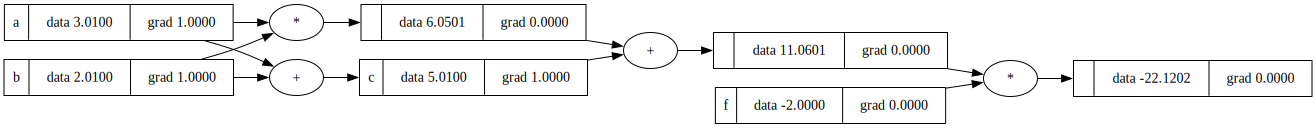

In [7]:
draw_dot(L)

In [8]:
def lol():
    
    h = 0.00001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)

lol()

-4.000000000026205


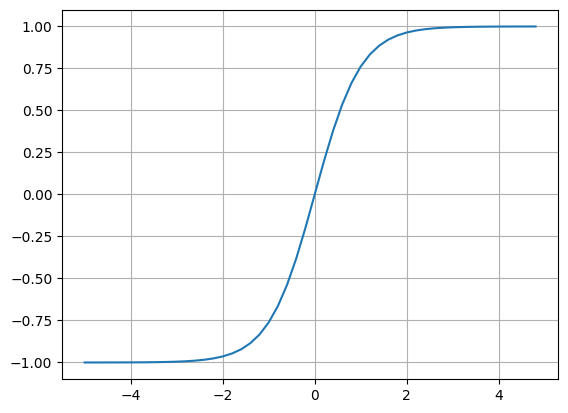

In [9]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

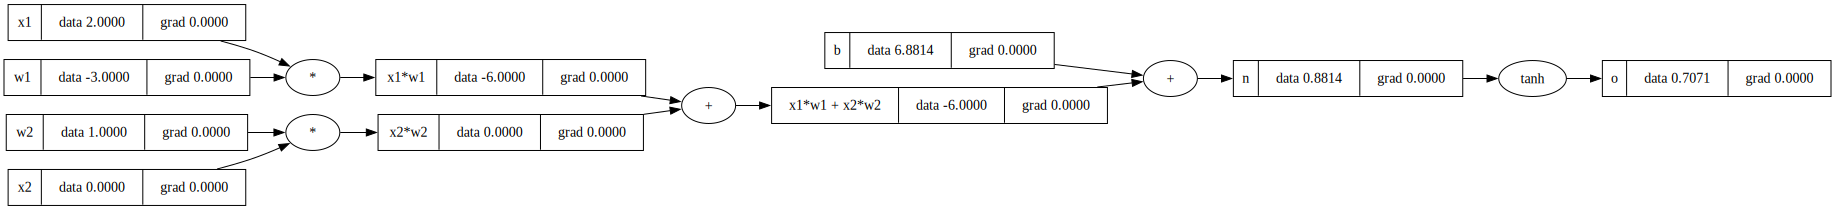

In [11]:
draw_dot(o)

In [12]:
o.backward()

In [13]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543, grad=0.4999999999999999),
 Value(data=2.0, grad=-1.4999999999999996),
 Value(data=-3.0, grad=0.9999999999999998),
 Value(data=-6.0, grad=0.4999999999999999),
 Value(data=1.0, grad=0.0),
 Value(data=0.0, grad=0.4999999999999999),
 Value(data=0.0, grad=0.4999999999999999),
 Value(data=-6.0, grad=0.4999999999999999),
 Value(data=0.8813735870195432, grad=0.4999999999999999),
 Value(data=0.7071067811865476, grad=1.0)]

In [14]:
o.grad = 1.0

In [15]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()

In [16]:
x2w2._backward()
x1w1._backward()

In [17]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [18]:
x1w1.grad = 0.5
x2w2.grad = 0.5

x1w1x2w2.grad = 0.5
b.grad = 0.5
n.grad = 0.5
o.grad = 1.0
1 - o.data**2

0.4999999999999999

o = tanh(n) \
do/dn = 1 - o**2

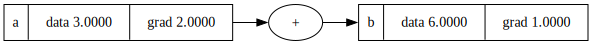

In [19]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

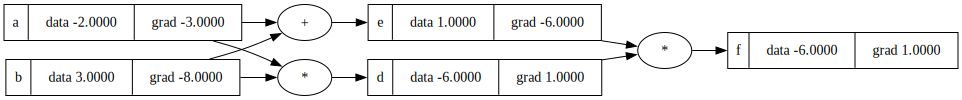

In [20]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

This works for `__add__` and `__mul__` but doesn't work for $2*a$ rather only works for $a*2$ \
Because, $a*2$ is translated to `a.__mul__(2)`
hence, we use `__rmul__`

In [21]:
a + 1

Value(data=-1.0, grad=0.0)

In [22]:
2*a

Value(data=-4.0, grad=0.0)

In [23]:
a*2

Value(data=-4.0, grad=0.0)

In [24]:
a/2

Value(data=-1.0, grad=0.0)

In [25]:
a ** 3

Value(data=-8.0, grad=0.0)

In [26]:
-a

Value(data=2.0, grad=0.0)

In [27]:
a - 4

Value(data=-6.0, grad=0.0)

## Proper RunThrough

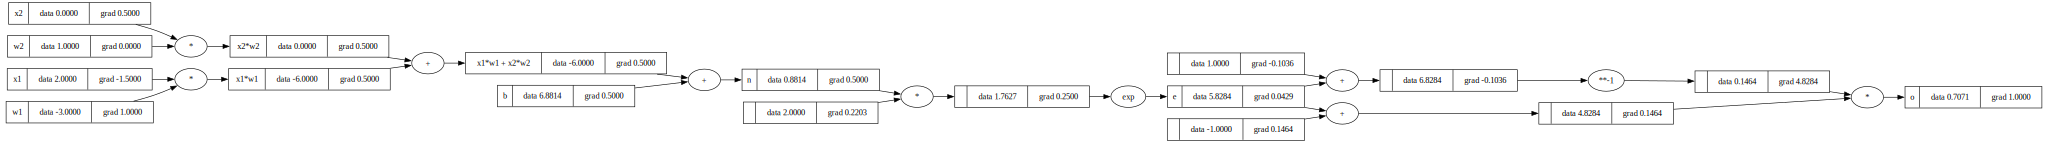

In [28]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -------
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e + 1)
# -------
o.label = 'o'
o.backward()
draw_dot(o)

## Doing the same in Pytorch

In [29]:
# !pip install torch

In [30]:
import torch

In [31]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----------')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
----------
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


## Implementation of a MultiLayer Perceptron

In [32]:
import random

In [33]:
class Neuron:
    def __init__(self, nin): # Neurons is a vector of Values as the weights and bias(s)
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x): # calling a neuron as a function would return the value of the below mentioned function
        # this neuron is basically an abstraction to the function w*x+b with x as the independent var
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, out): # Layer is basically a vector of neurons
        self.neurons = [Neuron(nin) for _ in range(out)]
    
    def __call__(self, x): # applying 'x' to all the neurons in this layer
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self): # unification
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

## Inputs form
```
x = [inputs]
n = MLP(input, [layer_sizes])
n(x)
```

In [34]:
x = [2.0, 3.0, -1.0] # Data
n = MLP(3, [4, 4, 1]) # Model with input and layer sizes
n(x)

Value(data=-0.1742366212350086, grad=0.0)

In [35]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired outputs

In [36]:
def mse(ys, ypred):
    return sum((Value(ygt) - yout)**2 for ygt, yout in zip(ys, ypred))

In [37]:
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = mse(ys, ypred)
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 3.5870400746365068
1 4.285197992792239
2 0.8685538136658799
3 0.47320592396515904
4 0.2600453671649442
5 0.1350356612606129
6 0.10059819682837028
7 0.08024945656102336
8 0.0663406614752794
9 0.0562774740596741
10 0.048691425393869246
11 0.042788146917960276
12 0.03807631566358209
13 0.034236675192653346
14 0.031053308108474946
15 0.02837525927697695
16 0.026093995320975897
17 0.02412959355231271
18 0.02242196945342663
19 0.020925128899690115


In [38]:
ypred

[Value(data=0.9321231332212079, grad=-0.13575373355758424),
 Value(data=-0.9428281734668804, grad=0.11434365306623917),
 Value(data=-0.908479540632362, grad=0.18304091873527595),
 Value(data=0.9316388441877433, grad=-0.13672231162451332)]